# 决策树

决策树可以使用不熟悉的数据集合，并从中提取出一系列规则

优点：
- 计算复杂度不高
- 输出结果易于理解
- 对中间值的缺失不敏感，可以处理不相关的特征数据

缺点：
- 可能会产生过度匹配问题

## 计算给定数据集的香农熵

计算公式：
$H=-\sum_{i=1}^{n}p(x_{i})\log_2p(x_{i})$

熵是描述数据混乱程度的，越大越混乱

In [1]:
import math

def calc_shannon_entropy(dataset):
    num_entries = len(dataset)
    labels = {}
    for feat_vec in dataset:
        cur_label = feat_vec[-1]
        if cur_label not in labels.keys():
            labels[cur_label] = 1
        else:
            labels[cur_label] += 1
        
    shannon_entropy = 0.
    for key in labels:
        prob = float(labels[key]) / num_entries # 以频率代替概率
        shannon_entropy -= prob * math.log2(prob)
    
    return shannon_entropy

In [2]:
def create_dataset():
    dataset = [[1, 1,  "yes"],
                      [1, 1, "yes"],
                      [1, 0, "no"],
                      [0, 1, "no"],
                      [0, 1, "no"]]
    labels = ["no surfacing", "flippers"]
    return dataset, labels

In [3]:
my_dataset, labels = create_dataset()

In [4]:
my_dataset

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [5]:
calc_shannon_entropy(my_dataset)

0.9709505944546686

In [6]:
# 添加分类，查看熵的变化
my_dataset[0][-1] = "maybe"
my_dataset

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [7]:
calc_shannon_entropy(my_dataset)

1.3709505944546687

## 划分数据集

In [8]:
# 根据给定特征划分数据集
def split_dataset(dataset, axis, value):
    """
    根据给定特征划分数据集
    dataset：待划分的数据集
    axis：划分数据集的特征（也就是第几列）
    value：如果这一列上某个值与value相同，则该条记录需返回
    """
    res = []
    for feat_vec in dataset:
        if feat_vec[axis] == value:
            # 下面的两行是抽取数据，同时该特征不能使用了，需要把这一列去掉
            reduced_feat_vec = feat_vec[:axis]
            reduced_feat_vec.extend(feat_vec[axis+1:])
            res.append(reduced_feat_vec)
    
    return res

In [9]:
my_dataset, labels = create_dataset()
my_dataset

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [10]:
print("分支1", split_dataset(my_dataset, 0, 0))
print("分支2", split_dataset(my_dataset, 0, 1))

分支1 [[1, 'no'], [1, 'no']]
分支2 [[1, 'yes'], [1, 'yes'], [0, 'no']]


In [11]:
# 选择最好的数据集划分方式
def choose_best_feature_to_split(dataset):
    num_features = len(dataset[0]) - 1# 获取特征数量
    base_entropy = calc_shannon_entropy(dataset)# 基本熵
#     print(f"基础信息熵为 {base_entropy}")
    best_info_gain = 0.
    best_feature = -1
    for i in range(num_features):
        feat_list = [example[i] for example in dataset]# 取当前列
        unique_vals = set(feat_list)# 去重
        
        new_entropy = 0.
        for val in unique_vals:
            sub_dataset = split_dataset(dataset, i, val)# 获取当前特征的分支
            prob = len(sub_dataset) / len(dataset)# 计算概率
            new_entropy += prob * calc_shannon_entropy(sub_dataset)# 计算单个集合的香农熵，然后累加
        
        info_gain = base_entropy - new_entropy# 信息增益
#         print(f"第 {i} 列的信息熵为 {new_entropy}，信息增益为 {info_gain}")
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = i
    
    return best_feature     

In [12]:
my_dataset, labels = create_dataset()
my_dataset

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [13]:
print("最好的特征是第 ", choose_best_feature_to_split(my_dataset), " 列")

最好的特征是第  0  列


## 递归构建决策树

In [14]:
import operator

# 返回出现次数最多的分类
def majority_cnt(class_list):
    class_cnt = {}
    for vote in class_list:
        if vote not in class_cnt.keys():
            class_cnt[vote] = 1
        else:
            class_cnt[vote] += 1
        sorted_class_cnt = sorted(class_cnt.items(), key=operator.itemgetter(1), reverse=True)
        return sorted_class_cnt[0][0]

In [15]:
# 创建决策树
def create_tree(dataset, labels):
    class_list = [example[-1] for example in dataset]
    # 类别完全相同
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]
    # 只有一个样本了，投票表决分类
    if len(dataset) == 1:
        return majority_cnt(class_list)
    # 选择最优特征
    best_feature = choose_best_feature_to_split(dataset)
    best_feature_label = labels[best_feature]
    my_tree = {best_feature_label:{}}
    del(labels[best_feature])# 删除改特征
    feature_vals = [example[best_feature] for example in dataset]
    unique_vals = set(feature_vals)# 去重
    for val in unique_vals:
        sub_labels = labels[:]
        my_tree[best_feature_label][val] = create_tree(split_dataset(dataset, best_feature, val), sub_labels)
    
    return my_tree

In [16]:
my_dataset, labels = create_dataset()
create_tree(my_dataset, labels)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 绘制树形图

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

decision_node = dict(boxstyle="sawtooth", fc="0.8")
leaf_node = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plot_node(node_txt, center_pt, parent_pt, node_type):
    create_plot.ax1.annotate(node_txt, xy=parent_pt,  xycoords='axes fraction',
                             xytext=center_pt, textcoords='axes fraction',
                             va="center", ha="center", bbox=node_type, arrowprops=arrow_args )

def create_plot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    create_plot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plot_node('决策节点', (0.5, 0.1), (0.1, 0.5), decision_node)
    plot_node('叶节点', (0.8, 0.1), (0.3, 0.8), leaf_node)
    plt.rcParams["font.sans-serif"]=["SimHei"]#显示中文标签 
    plt.rcParams["axes.unicode_minus"]=False
    plt.show()

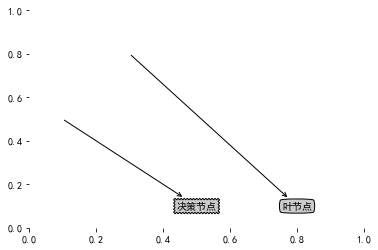

In [18]:
create_plot()

In [19]:
def get_num_leafs(my_tree):
    num_leafs = 0
    first_str = list(my_tree.keys())[0]# 这里需要强制转换
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            num_leafs += get_num_leafs(second_dict[key])
        else:   num_leafs +=1
    return num_leafs

In [20]:
def get_tree_depth(my_tree):
    max_depth = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            this_depth = 1 + get_tree_depth(second_dict[key])
        else:   this_depth = 1
        if this_depth > max_depth: max_depth = this_depth
    return max_depth

In [21]:
def retrieve_tree(i):
    list_of_trees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return list_of_trees[i]

In [22]:
retrieve_tree(1)

{'no surfacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}

In [23]:
my_tree = retrieve_tree(0)
# list(my_tree.keys())[0]

In [24]:
get_num_leafs(my_tree)

3

In [25]:
get_tree_depth(my_tree)

2

In [26]:
def plot_mid_text(cntr_pt, parent_pt, txt_string):
    x_mid = (parent_pt[0]-cntr_pt[0])/2.0 + cntr_pt[0]
    y_mid = (parent_pt[1]-cntr_pt[1])/2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_string, va="center", ha="center", rotation=30)

In [27]:
def plot_tree(my_tree, parent_pt, node_txt):#if the first key tells you what feat was split on
    num_leafs = get_num_leafs(my_tree)  #this determines the x width of this tree
    depth = get_tree_depth(my_tree)
    first_str = list(my_tree.keys())[0]    #the text label for this node should be this
    cntr_pt = (plot_tree.x_off + (1.0 + float(num_leafs))/2.0/plot_tree.total_w, plot_tree.y_off)
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, decision_node)
    second_dict = my_tree[first_str]
    plot_tree.y_off = plot_tree.y_off - 1.0/plot_tree.total_d
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plot_tree(second_dict[key],cntr_pt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plot_tree.x_off = plot_tree.x_off + 1.0/plot_tree.total_w
            plot_node(second_dict[key], (plot_tree.x_off, plot_tree.y_off), cntr_pt, leaf_node)
            plot_mid_text((plot_tree.x_off, plot_tree.y_off), cntr_pt, str(key))
    plot_tree.y_off = plot_tree.y_off + 1.0/plot_tree.total_d

In [28]:
def create_plot(in_tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #create_plot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plot_tree.total_w = float(get_num_leafs(in_tree))
    plot_tree.total_d = float(get_tree_depth(in_tree))
    plot_tree.x_off = -0.5/plot_tree.total_w
    plot_tree.y_off = 1.0;
    plot_tree(in_tree, (0.5,1.0), '')
    plt.show()

In [29]:
my_tree = retrieve_tree(0)

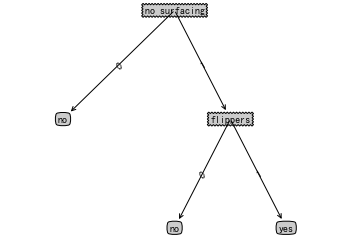

In [30]:
create_plot(my_tree)

In [31]:
my_tree["no surfacing"][2] = "unknown"
my_tree["no surfacing"][3] = "maybe"
my_tree

{'no surfacing': {0: 'no',
  1: {'flippers': {0: 'no', 1: 'yes'}},
  2: 'unknown',
  3: 'maybe'}}

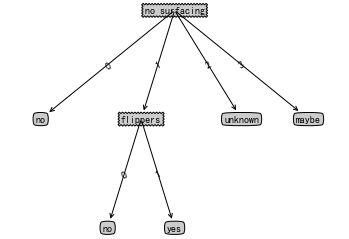

In [32]:
create_plot(my_tree)

## 使用决策树进行分类

In [33]:
# 根据给定的编码从树中查询所属类别
def classify(input_tree, feature_lables, test_vec):
    first_str = list(input_tree.keys())[0]# 这里需要强制转换
    second_dict = input_tree[first_str]
    feature_index = feature_lables.index(first_str)
    for key in second_dict.keys():
        if test_vec[feature_index] == key:
            if type(second_dict[key]).__name__ == 'dict':# test to see if the nodes are dictonaires, if not they are leaf nodes
                class_label = classify(second_dict[key], feature_lables, test_vec)
            else:   
                class_label = second_dict[key]
    return class_label

In [34]:
my_dataset, labels = create_dataset()

In [35]:
labels

['no surfacing', 'flippers']

In [36]:
my_tree = retrieve_tree(0)
my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [37]:
classify(my_tree, labels, [1, 0])

'no'

In [38]:
classify(my_tree, labels, [1, 1])

'yes'

## 决策树持久化

In [39]:
import pickle

# 存储决策树
def store_tree(input_tree, filename):
    fw = open(filename, "wb")
    pickle.dump(input_tree, fw)
    fw.close()

In [40]:
# 从文件读取决策树    
def grab_tree(filename):
    fr = open(filename, "rb")
    res = pickle.load(fr)
    fr.close()
    return res

In [41]:
my_tree = retrieve_tree(0)
my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [42]:
store_tree(my_tree, "dump_tree.txt")

In [43]:
grab_tree("dump_tree.txt")

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# 使用决策树预测隐形眼镜类型

In [44]:
fp = open("dataset/lenses.txt")
lenses =[example.strip().split("\t") for example in fp.readlines()]
fp.close()

lenses

[['young', 'myope', 'no', 'reduced', 'no lenses'],
 ['young', 'myope', 'no', 'normal', 'soft'],
 ['young', 'myope', 'yes', 'reduced', 'no lenses'],
 ['young', 'myope', 'yes', 'normal', 'hard'],
 ['young', 'hyper', 'no', 'reduced', 'no lenses'],
 ['young', 'hyper', 'no', 'normal', 'soft'],
 ['young', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['young', 'hyper', 'yes', 'normal', 'hard'],
 ['pre', 'myope', 'no', 'reduced', 'no lenses'],
 ['pre', 'myope', 'no', 'normal', 'soft'],
 ['pre', 'myope', 'yes', 'reduced', 'no lenses'],
 ['pre', 'myope', 'yes', 'normal', 'hard'],
 ['pre', 'hyper', 'no', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'no', 'normal', 'soft'],
 ['pre', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'yes', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'normal', 'hard'],
 ['presbyopic', 

In [45]:
lenses_labels = ["age", "prescript", "astigmatic", "tearRate"]# 用来分类的特征

In [46]:
lense_tree = create_tree(lenses, lenses_labels.copy())

In [47]:
lense_tree

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'no': {'age': {'young': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'pre': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'young': 'hard',
        'presbyopic': 'no lenses',
        'pre': 'no lenses'}},
      'myope': 'hard'}}}}}}

In [48]:
store_tree(lense_tree, "dump_lense_tree.txt")

In [49]:
grab_tree("dump_lense_tree.txt")

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'no': {'age': {'young': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'pre': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'young': 'hard',
        'presbyopic': 'no lenses',
        'pre': 'no lenses'}},
      'myope': 'hard'}}}}}}

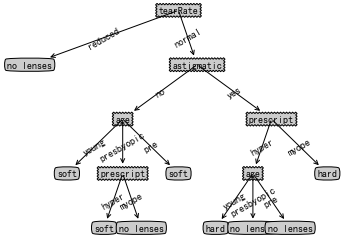

In [50]:
create_plot(lense_tree)